# Machine Learning Capstone Project

#### By: Wesley Strange

## Import Libraries and Data

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime

file_path = 'C:\\Users\\wesle\\Documents\\Machine Learning Nanodegree\\Machine Learning Capstone\\Capstone Project\\Data\\'

crime_data = pd.read_csv(file_path+'Crimes_-_2001_to_present.csv')
weather_data = pd.read_csv(file_path+'Beach_Weather_Stations_-_Automated_Sensors.csv')
bitcoin_data = pd.read_excel(file_path+'Bitcoin_Historical_Data.xlsx', sheetname='Sheet1')
dowjones_data = pd.read_excel(file_path+'Dow_Jones_Historical_Data.xlsx', sheetname='Sheet1')
baseball_data = pd.read_excel(file_path+'Chicago_Sports_Data.xlsx', sheetname='Baseball')
basketball_data = pd.read_excel(file_path+'Chicago_Sports_Data.xlsx', sheetname='Basketball')
football_data = pd.read_excel(file_path+'Chicago_Sports_Data.xlsx', sheetname='Football')
hockey_data = pd.read_excel(file_path+'Chicago_Sports_Data.xlsx', sheetname='Hockey')

## Data Preparation

### Prepare Crime Data

The more serious criminal offenses includes the following Crime Categories:
- Homicide 1st & 2nd Degree (01A) (Index)
- Criminal Sexual Assault (02) (Index)
- Robbery (03) (Index)
- Aggravated Assault (04A) (Index)
- Aggravated Battery (04B) (Index)
- Burglary (05) (Index)
- Larceny (06) (Index)
- Motor Vehicle Theft (07) (Index)
- Arson (09) (Index)

Source: http://gis.chicagopolice.org/clearmap_crime_sums/crime_types.html 

#### Sample of Crime Data

In [3]:
crime_data.sample(5)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
3921428,8928363,HV600153,12/12/2012 08:30:00 AM,038XX N LINCOLN AVE,0810,THEFT,OVER $500,PARKING LOT/GARAGE(NON.RESID.),False,False,...,47.0,5.0,06,1162738.0,1925738.0,2012,02/10/2018 03:50:01 PM,41.951879,-87.677171,"(41.951879466, -87.677171063)"
5023163,3757801,HL103337,01/02/2005 09:59:00 PM,047XX W JACKSON BLVD,0560,ASSAULT,SIMPLE,OTHER,False,False,...,24.0,25.0,08A,1144908.0,1898272.0,2005,02/28/2018 03:56:25 PM,41.876866,-87.743409,"(41.876865807, -87.743409103)"
6222685,6982024,HR387076,06/21/2009 01:13:00 PM,011XX N LAWNDALE AVE,1661,GAMBLING,GAME/DICE,SIDEWALK,True,False,...,27.0,23.0,19,1151504.0,1907287.0,2009,02/28/2018 03:56:25 PM,41.901477,-87.718953,"(41.901476939, -87.718953402)"
938581,2071835,HH293923,04/08/2002 05:14:02 PM,017XX N KOSTNER AV,0820,THEFT,$500 AND UNDER,GROCERY FOOD STORE,True,False,...,NaN,NaN,06,1146787.0,1911143.0,2002,02/28/2018 03:56:25 PM,41.912150,-87.736181,"(41.912149595, -87.736181)"
2157199,9437262,HW575141,04/01/2011 12:00:00 AM,043XX W PALMER ST,1562,SEX OFFENSE,AGG CRIMINAL SEXUAL ABUSE,RESIDENCE,False,True,...,31.0,20.0,17,1146885.0,1914265.0,2011,02/04/2016 06:33:39 AM,41.920715,-87.735741,"(41.920714799, -87.735741053)"


#### Create New DataFrame Containing Violent Crimes Per Day

In [4]:
# Update date field to datetime value
def update_date(row):
    return pd.to_datetime(row['Date'])
crime_data["Date"] = crime_data.apply(update_date, axis = 1)

# Remove all data prior to 5/22/2015 since that is how far the weather data goes back
crime_data = crime_data[crime_data["Date"] >= "2015-05-22"]

# remove data that is not considered one of the more serious criminal offenses
crime_data = crime_data[crime_data["Primary Type"].str.contains("HOMICIDE") 
                        | crime_data["Primary Type"].str.contains("CRIM SEXUAL ASSAULT")
                        | crime_data["Primary Type"].str.contains("ROBBERY")
                        | crime_data["Primary Type"].str.contains("ASSAULT")
                        | crime_data["Primary Type"].str.contains("BATTERY")
                        | crime_data["Primary Type"].str.contains("BURGLARY")
                        | crime_data["Primary Type"].str.contains("MOTOR VEHICLE THEFT")
                        | crime_data["Primary Type"].str.contains("ARSON")]

# Update date field to contain just the Date (removes timestamp)
crime_data['Date'] = crime_data['Date'].apply(lambda x: x.date())

# Create a new DataFrame that contains the number of violent crimes committed per day
crime_count = crime_data.groupby("Date")["ID"].count()
crime_data_updated = pd.DataFrame(columns = ["Date", "Crime"])
for i, v in crime_count.iteritems():
    crime_data_updated = crime_data_updated.append({'Date': i, 'Crime': v}, ignore_index=True)
crime_data_updated.head()

,Date,Crime
0,2015-05-22,320
1,2015-05-23,303
2,2015-05-24,312
3,2015-05-25,326
4,2015-05-26,309


#### Determine High Volume Crime Days

In [5]:
# Print out statistical info for crime_count
crime_count.describe()

count    1278.000000
mean      293.392801
std        38.334643
min       186.000000
25%       267.000000
50%       293.000000
75%       317.000000
max       420.000000
Name: ID, dtype: float64

In [6]:
# Determine if the day should be considered a high crime day
# Threshold: 317 since that is the 75th percentile
# 1: high crime day
# 0: not a high crime day
for index, row in crime_data_updated.iterrows():
    if row["Crime"] >= 317:
        crime_data_updated.loc[index, "High Crime Day?"] = 1
    else:
        crime_data_updated.loc[index, "High Crime Day?"] = 0

# Drop the "Crime" field from the crime_data_updated DataFrame
crime_data_updated = crime_data_updated.drop(["Crime"], axis = 1)

# Print out a summary of high crime days
print(crime_data_updated.groupby("High Crime Day?")["High Crime Day?"].count())

High Crime Day?
0.0    954
1.0    324
Name: High Crime Day?, dtype: int64


In [7]:
# Print out first 5 rows of the crime_data_updated DataFrame
crime_data_updated.head()

,Date,High Crime Day?
0,2015-05-22,1.0
1,2015-05-23,0.0
2,2015-05-24,0.0
3,2015-05-25,1.0
4,2015-05-26,0.0


### Prepare Weather Data

#### Sample of Weather Data

In [8]:
# Print out sample of the weather_data DataFrame
weather_data.sample(5)

,Station Name,Measurement Timestamp,Air Temperature,Wet Bulb Temperature,Humidity,Rain Intensity,Interval Rain,Total Rain,Precipitation Type,Wind Direction,Wind Speed,Maximum Wind Speed,Barometric Pressure,Solar Radiation,Heading,Battery Life,Measurement Timestamp Label,Measurement ID
46234,63rd Street Weather Station,5/2/2017 12:00,8.40,5.6,66.0,0.0,0.0,2.0,0.0,285.0,6.4,11.4,984.6,379.0,354.0,11.9,5/2/2017 12:00,63rdStreetWeatherStation201705021200
30277,Foster Weather Station,9/16/2016 22:00,24.39,NaN,70.0,NaN,0.0,NaN,NaN,188.0,2.9,3.2,990.5,0.0,NaN,15.1,9/16/2016 22:00,FosterWeatherStation201609162200
45851,63rd Street Weather Station,4/26/2017 20:00,21.80,17.2,64.0,0.0,0.0,57.5,60.0,275.0,3.1,4.8,975.5,1.0,355.0,12.0,4/26/2017 20:00,63rdStreetWeatherStation201704262000
28875,63rd Street Weather Station,8/28/2016 2:00,25.30,23.7,88.0,0.0,0.0,781.1,0.0,248.0,1.2,1.6,997.2,0.0,355.0,11.9,8/28/2016 2:00,63rdStreetWeatherStation201608280200
8412,63rd Street Weather Station,10/10/2015 8:00,10.40,8.9,83.0,0.0,0.0,1.4,0.0,263.0,1.5,2.0,1001.4,30.0,355.0,11.9,10/10/2015 8:00,63rdStreetWeatherStation201510100800


#### Filter Data to Just One Weather Station

I will use the Foster Weather Station since it has the most data points

In [9]:
print(weather_data.groupby("Station Name")["Measurement Timestamp"].count())

Station Name
63rd Street Weather Station    27134
Foster Weather Station         29094
Oak Street Weather Station     24716
Name: Measurement Timestamp, dtype: int64


In [10]:
weather_data = weather_data[weather_data["Station Name"] == "Foster Weather Station"]

#### Create New DataFrame Containing Weather Avearages by Day

In [11]:
# Update "Measurement Timestamp" to Datetime.Date() value
weather_data['Measurement Timestamp'] = pd.to_datetime(weather_data['Measurement Timestamp'])
weather_data["Date"] = weather_data["Measurement Timestamp"].apply(lambda x: x.date())

# Remove Data Prior to 5/22/2015 and after 11/19/2018
weather_data = weather_data[(weather_data["Date"] >= datetime.strptime("22-05-2015", "%d-%m-%Y").date())
                           & (weather_data["Date"] <= datetime.strptime("19-11-2018", "%d-%m-%Y").date())]

# Create new DataFrame grouped by day and aggregated by weather measurements
weather_data_updated = weather_data.groupby("Date").agg({"Air Temperature": [np.mean], 
                                                         "Humidity": [np.mean], 
                                                         "Interval Rain": [np.mean], 
                                                         "Wind Speed": [np.mean], 
                                                         "Barometric Pressure": [np.mean]})
weather_data_updated.columns = ["Air_Temperature", "Humidity", "Rain", "Wind_Speed", "Barometric_Pressure"]
weather_data_updated.index.names = ["Date"]
weather_data_updated.reset_index(level=0, inplace=True)

# Print out first 5 rows of the weather_data_updated DataFrame
weather_data_updated.head()

,Date,Air_Temperature,Humidity,Rain,Wind_Speed,Barometric_Pressure
0,2015-05-22,9.695000,60.000000,0.000000,2.250000,NaN
1,2015-05-23,15.784000,52.533333,0.000000,2.173333,NaN
2,2015-05-24,16.507368,67.105263,0.610526,1.831579,NaN
3,2015-05-25,23.500000,62.173913,0.165217,5.130435,NaN
4,2015-05-26,20.851500,74.400000,0.622000,3.985000,986.875


### Prepare Bitcoin Data

#### Sample of Bitcoin Data

In [12]:
# Print out first 5 rows of the bitcoin_data DataFrame
bitcoin_data.head(5)

,Date,Open*,High,Low,Close**,Volume,Market Cap
0,2018-12-02,4200.73,4301.52,4110.98,4139.88,5262697895,72050487506
1,2018-12-01,4024.46,4309.38,3969.71,4214.67,5375314093,73346194969
2,2018-11-30,4289.09,4322.98,3942.82,4017.27,6048016717,69904637061
3,2018-11-29,4269.00,4413.02,4145.77,4278.85,6503347767,74451016927
4,2018-11-28,3822.47,4385.90,3822.47,4257.42,7280280000,74072560088


#### Modify DataFrame to Contain Open, Close, and Daily Change values by Day

In [13]:
# Update "Date" variable to Datetime.Date() value
bitcoin_data['Date'] = pd.to_datetime(bitcoin_data['Date'])
bitcoin_data["Date"] = bitcoin_data["Date"].apply(lambda x: x.date())

# Remove all data prior to 5/22/2015 and after 11/19/2018
bitcoin_data = bitcoin_data[(bitcoin_data["Date"] >= datetime.strptime("22-05-2015", "%d-%m-%Y").date())
                           & (bitcoin_data["Date"] <= datetime.strptime("19-11-2018", "%d-%m-%Y").date())]

# Create new variable "Daily Change" that is the variance between Open and CLose prices
def calculate_daily_change(row):
    return row["Close**"] - row["Open*"]
bitcoin_data["Daily Change"] = bitcoin_data.apply(calculate_daily_change, axis = 1)

# Remove variables that are not needed for the ML model
bitcoin_data = bitcoin_data.drop(["High", "Low", "Market Cap", "Volume", "Open*", "Close**"], axis = 1)

# Rename columns
bitcoin_data = bitcoin_data.rename(index = str, columns = {"Daily Change": "BC_Daily_Change"})

# Print out first 5 rows of the bitcoin_data DataFrame
bitcoin_data.head()

,Date,BC_Daily_Change
13,2018-11-19,-749.29
14,2018-11-18,63.80
15,2018-11-17,-24.25
16,2018-11-16,-69.77
17,2018-11-15,-88.12


### Prepare Dow Jones Data

#### Sample of Dow Jones Data

In [14]:
dowjones_data.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-12-02,16087.120117,16098.000000,15986.230469,16008.769531,16008.769531,92590000
1,2013-12-03,16004.719727,16004.719727,15859.679688,15914.620117,15914.620117,103910000
2,2013-12-04,15910.509766,15960.360352,15791.290039,15889.769531,15889.769531,111180000
3,2013-12-05,15886.500000,15896.190430,15809.370117,15821.509766,15821.509766,128080000
4,2013-12-06,15825.549805,16022.349609,15825.549805,16020.200195,16020.200195,98260000


#### Modify DataFrame to Contain Open, Close, and Daily Change values by Day

In [15]:
# Update "Date" field to Datetime.Date() value
dowjones_data['Date'] = pd.to_datetime(dowjones_data['Date'])
dowjones_data["Date"] = dowjones_data["Date"].apply(lambda x: x.date())

# Remove all data prior to 5/22/2015 and after 11/19/2018
dowjones_data = dowjones_data[(dowjones_data["Date"] >= datetime.strptime("22-05-2015", "%d-%m-%Y").date())
                              & (dowjones_data["Date"] <= datetime.strptime("19-11-2018", "%d-%m-%Y").date())]

# Create new variable "Daily Change" that is the variance betwen Open and CLose prices
def calculate_daily_variance(row):
    return row["Close"] - row["Open"]
dowjones_data["Daily Change"] = dowjones_data.apply(calculate_daily_variance, axis = 1)

# remove variables that are not needed for the ML model
dowjones_data = dowjones_data.drop(["High", "Low", "Adj Close", "Volume", "Open", "Close"], axis = 1)

# Rename columns
dowjones_data = dowjones_data.rename(index = str, columns = {"Daily Change": "DOW_Daily_Change"})

# Print out first 5 rows of dowjones_data DataFrame
dowjones_data.head()

,Date,DOW_Daily_Change
370,2015-05-22,-54.849610
371,2015-05-26,-188.210937
372,2015-05-27,117.910156
373,2015-05-28,-28.021484
374,2015-05-29,-117.439453


### Prepare Baseball Data

#### Sample of Baseball Data

In [16]:
baseball_data.sample(5)

,Year,Gm#,Date,Tm,Home/Away,Opp,W/L,R,RA,Inn,...,Rank,GB,Win,Loss,Save,Time,D/N,Attendance,Streak,Orig. Scheduled
334,2016,15,"Wednesday, Apr 20",CHC,@,STL,L,3,5,NaN,...,1,up 3.0,Martinez,Hendricks,Rosenthal,02:40:00,D,43093.0,-,NaN
574,2015,97,"Sunday, Jul 26",CHC,NaN,PHI,L,5,11,NaN,...,3,11.5,Nola,Hammel,NaN,03:01:00,D,41123.0,---,NaN
1084,2017,130,"Tuesday, Aug 29",CHW,@,MIN,L,4,6,NaN,...,5,22,Santana,Shields,Belisle,03:12:00,N,20530.0,-,NaN
229,2017,72,"Thursday, Jun 22",CHC,@,MIA,W,11,1,NaN,...,2,1.5,Arrieta,Locke,NaN,02:54:00,N,23472.0,+,NaN
1108,2017,154,"Saturday, Sep 23",CHW,NaN,KCR,L,2,8,NaN,...,4,34.5,Duffy,Covey,NaN,03:02:00,N,20306.0,-,NaN


#### Update / Remove Variables

In [17]:
# Split the Date into 3 segments.. 
#   1) day of week, 
#   2) Month, 
#   3) Day
# Then, assign datetime value to Date variable
import datetime

for index, row in baseball_data.iterrows():
    year = row["Year"]
    _, month, day = row["Date"].split(" ")
    
    if month == "Mar":
        month = 3
    elif month == "Apr": 
        month = 4
    elif month == "May":
        month = 5
    elif month == "Jun":
        month = 6
    elif month == "Jul":
        month = 7
    elif month == "Aug":
        month = 8
    elif month == "Sep":
        month = 9
    elif month == "Oct":
        month = 10
    else:
        month = 11
        
    dt = datetime.datetime(year = int(year), month = int(month), day = int(day)).date()
    baseball_data.loc[index, "Date"] = dt

# Update Home/Away
for index, row in baseball_data.iterrows():
    if row["Home/Away"] == "@":
        baseball_data.loc[index, "Home/Away"] = "Away"
    else:
        baseball_data.loc[index, "Home/Away"] = "Home"
        
# remove variables that are not needed for the ML model
baseball_data = baseball_data.drop(["Year", "Gm#", "W-L", "GB", "Win", "Loss",
                                   "Save", "Time", "D/N", "Streak", "Orig. Scheduled", 
                                   "R", "RA", "Inn", "Rank", "Attendance"], 
                                   axis = 1)

#### Create Two New DataFrames for Cubs and Sox

In [18]:
# Create separate DataFrames for Cubs and Sox
cubs_baseball_data = baseball_data[baseball_data["Tm"] == "CHC"]
sox_baseball_data = baseball_data[baseball_data["Tm"] == "CHW"]

# remove variables that are not needed for the ML model
cubs_baseball_data = cubs_baseball_data.drop(["Tm"], axis = 1)

# Rename columns
cubs_baseball_data = cubs_baseball_data.rename(index = str, columns = {"Home/Away": "Cubs_H/A", 
                                                                       "Opp": "Cubs_Opp", 
                                                                       "W/L": "Cubs_Result"})

# Print out first 5 rows of the cubs_baseball_data DataFrame
cubs_baseball_data.head()

,Date,Cubs_H/A,Cubs_Opp,Cubs_Result
0,2018-03-29,Away,MIA,W
1,2018-03-30,Away,MIA,L
2,2018-03-31,Away,MIA,W
3,2018-04-01,Away,MIA,L
4,2018-04-02,Away,CIN,L


In [19]:
# remove variables that are not needed for the ML model
sox_baseball_data = sox_baseball_data.drop(["Tm"], axis = 1)

# Rename columns
sox_baseball_data = sox_baseball_data.rename(index = str, columns = {"Home/Away": "Sox_H/A", 
                                                                       "Opp": "Sox_Opp", 
                                                                       "W/L": "Sox_Result"})

# Print out the first 5 rows of the sox_baseball_data DataFrame
sox_baseball_data.head()

,Date,Sox_H/A,Sox_Opp,Sox_Result
638,2015-04-06,Away,KCR,L
639,2015-04-08,Away,KCR,L
640,2015-04-09,Away,KCR,L
641,2015-04-10,Home,MIN,L
642,2015-04-11,Home,MIN,W


### Prepare Basketball Data

#### Sample of Basketball Data

In [20]:
basketball_data.head()

,Year,G,Date,Start (ET),Home/Away,Opponent,Result,Tm,Opp,W,L,Streak,Notes
0,2017-18,1,"Thu, Oct 19, 2017",7:30p,@,Toronto Raptors,L,100,117,0,1,L 1,NaN
1,2017-18,2,"Sat, Oct 21, 2017",8:00p,NaN,San Antonio Spurs,L,77,87,0,2,L 2,NaN
2,2017-18,3,"Tue, Oct 24, 2017",7:00p,@,Cleveland Cavaliers,L,112,119,0,3,L 3,NaN
3,2017-18,4,"Thu, Oct 26, 2017",8:00p,NaN,Atlanta Hawks,W,91,86,1,3,W 1,NaN
4,2017-18,5,"Sat, Oct 28, 2017",8:00p,NaN,Oklahoma City Thunder,L,69,101,1,4,L 1,NaN


#### Update / Remove Variables

In [21]:
for index, row in basketball_data.iterrows():
    _, month, day, year = row["Date"].split(' ')
    day = day.replace(",", "")
    
    if month == "Jan":
        month = 1
    elif month == "Feb": 
        month = 2
    elif month == "Mar":
        month = 3
    elif month == "Apr": 
        month = 4
    elif month == "May":
        month = 5
    elif month == "Jun":
        month = 6
    elif month == "Jul":
        month = 7
    elif month == "Aug":
        month = 8
    elif month == "Sep":
        month = 9
    elif month == "Oct":
        month = 10
    elif month == "Nov":
        month = 11
    else:
        month = 12
        
    dt = datetime.datetime(year = int(year), month = int(month), day = int(day)).date()
    basketball_data.loc[index, "Date"] = dt

    
# Update Home/Away
for index, row in basketball_data.iterrows():
    if row["Home/Away"] == "@":
        basketball_data.loc[index, "Home/Away"] = "Away"
    else:
        basketball_data.loc[index, "Home/Away"] = "Home"
        

# remove variables that are not needed for the ML model
basketball_data = basketball_data.drop(["Year", "G", "Start (ET)", "Tm", "Opp", "W", "L", 
                                    "Streak", "Notes"], axis = 1)

# Rename columns
basketball_data = basketball_data.rename(index = str, columns = {"Home/Away": "Basketball_H/A", 
                                                                 "Opponent": "Basketball_Opp", 
                                                                 "Result": "Basketball_Result"})

# Print out the first 5 rows of the basketball_data DataFrame
basketball_data.head()

,Date,Basketball_H/A,Basketball_Opp,Basketball_Result
0,2017-10-19,Away,Toronto Raptors,L
1,2017-10-21,Home,San Antonio Spurs,L
2,2017-10-24,Away,Cleveland Cavaliers,L
3,2017-10-26,Home,Atlanta Hawks,W
4,2017-10-28,Home,Oklahoma City Thunder,L


### Prepare Football Data

#### Sample of Football Data

In [22]:
football_data.head(5)

,Year,Week,Day,Date,Result,OT,Home/Away,Opponent,Tm,Opp,...,FGA,XPM,XPA,Pnt,Yds.3,3DConv,3DAtt,4DConv,4DAtt,ToP
0,2018,1,Sun,2018-09-09,L,NaN,@,Green Bay Packers,23,24,...,3,2,2,4,201,7,17,0,2,1900-01-01 09:22:00
1,2018,2,Mon,2018-09-17,W,NaN,NaN,Seattle Seahawks,24,17,...,1,3,3,5,206,5,12,1,1,1900-01-01 10:24:00
2,2018,3,Sun,2018-09-23,W,NaN,@,Arizona Cardinals,16,14,...,4,1,1,3,158,5,14,1,1,1900-01-01 12:21:00
3,2018,4,Sun,2018-09-30,W,NaN,NaN,Tampa Bay Buccaneers,48,10,...,2,6,6,2,96,4,8,0,0,1900-01-01 04:06:00
4,2018,6,Sun,2018-10-14,L,OT,@,Miami Dolphins,28,31,...,1,4,4,2,79,8,12,0,1,1900-01-01 09:25:00


#### Update / Remove Variables

In [23]:
# Update "Date" field to Datetime.Date() value
football_data['Date'] = pd.to_datetime(football_data['Date'])
football_data["Date"] = football_data["Date"].apply(lambda x: x.date())

# Update Home/Away
for index, row in football_data.iterrows():
    if row["Home/Away"] == "@":
        football_data.loc[index, "Home/Away"] = "Away"
    else:
        football_data.loc[index, "Home/Away"] = "Home"
        
# remove variables that are not needed for the ML model
football_data = football_data.drop(["Year", "Week", "Day", "OT", "Tm", "Opp", "Cmp", 
                                   "Att", "Yds", "TD", "Int", "Sk", "Yds.1", "Y/A", 
                                   "Cmp%", "Rate", "Att.1", "Yds.2", "Y/A.1", "TD.1", 
                                   "FGM", "FGA", "XPM", "XPA", "Pnt", "Yds.3", "3DConv", 
                                   "3DAtt", "4DConv", "4DAtt", "ToP"], axis = 1)

# Rename columns
football_data = football_data.rename(index = str, columns = {"Home/Away": "Football_H/A", 
                                                             "Opponent": "Football_Opp", 
                                                             "Result": "Football_Result"})

# Print out the first 5 rows of the football_data DataFrame
football_data.head()

,Date,Football_Result,Football_H/A,Football_Opp
0,2018-09-09,L,Away,Green Bay Packers
1,2018-09-17,W,Home,Seattle Seahawks
2,2018-09-23,W,Away,Arizona Cardinals
3,2018-09-30,W,Home,Tampa Bay Buccaneers
4,2018-10-14,L,Away,Miami Dolphins


### Prepare Hockey Data

#### Sample of Hockey Data

In [24]:
hockey_data.head()

,GP,Date,Home/Away,Opponent,GF,GA,Result,W,L,OL,Streak,Att.,LOG,Notes
0,1,2018-10-04,@,Ottawa Senators,4,3,W,1.0,0.0,0.0,W 1,15858.0,02:38:00,NaN
1,2,2018-10-06,@,St. Louis Blues,5,4,W,2.0,0.0,0.0,W 2,17429.0,02:39:00,NaN
2,3,2018-10-07,NaN,Toronto Maple Leafs,6,7,L,2.0,0.0,1.0,L 1,21812.0,02:31:00,NaN
3,4,2018-10-11,@,Minnesota Wild,3,4,L,2.0,0.0,2.0,L 2,18652.0,02:42:00,NaN
4,5,2018-10-13,NaN,St. Louis Blues,4,3,W,3.0,0.0,2.0,W 1,21634.0,02:38:00,NaN


#### Update / Remove Variables

In [25]:
# Update "Date" field to Datetime.Date() values
hockey_data['Date'] = pd.to_datetime(hockey_data['Date'])
hockey_data["Date"] = hockey_data["Date"].apply(lambda x: x.date())

# Update Home/Away
for index, row in hockey_data.iterrows():
    if row["Home/Away"] == "@":
        hockey_data.loc[index, "Home/Away"] = "Away"
    else:
        hockey_data.loc[index, "Home/Away"] = "Home"
        
# remove variables that are not needed for the ML model
hockey_data = hockey_data.drop(["GP", "GF", "GA", "W", "L", "OL", "Streak", "Att.", 
                                   "LOG", "Notes"], axis = 1)

# Rename columns
hockey_data = hockey_data.rename(index = str, columns = {"Home/Away": "Hockey_H/A", 
                                                         "Opponent": "Hockey_Opp", 
                                                         "Result": "Hockey_Result"})

# Print out first 5 rows of the hockey_data DataFrame
hockey_data.head()

,Date,Hockey_H/A,Hockey_Opp,Hockey_Result
0,2018-10-04,Away,Ottawa Senators,W
1,2018-10-06,Away,St. Louis Blues,W
2,2018-10-07,Home,Toronto Maple Leafs,L
3,2018-10-11,Away,Minnesota Wild,L
4,2018-10-13,Home,St. Louis Blues,W


### Merge All Data into crime_data_updated DataFrame

In [26]:
# Merge crime_data_updated DataFrame with the other DataFrames
# weather_data_updated
# bitcoin_data
# dowjones_data
# cubs_baseball_data
# sox_baseball_data
# basketball_data
# football_data
# hockey_data
crime_data_updated = pd.merge(crime_data_updated, weather_data_updated, how = "left", left_on = "Date", right_on = "Date")
crime_data_updated = pd.merge(crime_data_updated, bitcoin_data, how = "left", left_on = "Date", right_on = "Date")
crime_data_updated = pd.merge(crime_data_updated, dowjones_data, how = "left", left_on = "Date", right_on = "Date")
crime_data_updated = pd.merge(crime_data_updated, cubs_baseball_data, how = "left", left_on = "Date", right_on = "Date")
crime_data_updated = pd.merge(crime_data_updated, sox_baseball_data, how = "left", left_on = "Date", right_on = "Date")
crime_data_updated = pd.merge(crime_data_updated, basketball_data, how = "left", left_on = "Date", right_on = "Date")
crime_data_updated = pd.merge(crime_data_updated, football_data, how = "left", left_on = "Date", right_on = "Date")
crime_data_updated = pd.merge(crime_data_updated, hockey_data, how = "left", left_on = "Date", right_on = "Date")

# Print out a list of the column names for crime_data_updated
list(crime_data_updated)

['Date',
 'High Crime Day?',
 'Air_Temperature',
 'Humidity',
 'Rain',
 'Wind_Speed',
 'Barometric_Pressure',
 'BC_Daily_Change',
 'DOW_Daily_Change',
 'Cubs_H/A',
 'Cubs_Opp',
 'Cubs_Result',
 'Sox_H/A',
 'Sox_Opp',
 'Sox_Result',
 'Basketball_H/A',
 'Basketball_Opp',
 'Basketball_Result',
 'Football_Result',
 'Football_H/A',
 'Football_Opp',
 'Hockey_H/A',
 'Hockey_Opp',
 'Hockey_Result']

### Add Holiday Data

Note: The USFederalHolidayCalendar list only includes the US Federal National Holidays (business holiday dates). I added in the weekend weekend dates associated with the Holidays as well which is when a lot of the partying could be going on.

In [27]:
# Import US Federal Holidays from 05/22/2015 - 11/19/2018
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2015-05-22', end='2018-11-19').to_pydatetime()
holidays_set = set()
for h in holidays:
    holidays_set.add(h.date())

# Add additional Holiday dates (weekends / party days)
other_dates = ["2015-05-23", "2015-05-24", "2015-07-04", "2015-07-05", "2015-09-05", 
              "2015-10-31", "2015-11-25", "2015-11-27", "2015-11-28", "2015-11-29", 
               "2015-12-24", "2015-12-26", "2015-12-27", "2015-12-31", "2016-02-13", 
              "2016-02-14", "2016-03-12", "2016-03-13", "2016-03-19", "2016-03-20", 
              "2016-05-05", "2016-05-06", "2016-05-07", "2016-05-08", "2016-05-28", 
              "2016-05-29", "2016-07-02", "2016-07-03", "2016-09-03", "2016-09-04", 
              "2016-10-29", "2016-10-31", "2016-11-05", "2016-11-25", "2016-11-26", 
              "2016-11-27", "2016-12-24", "2016-12-25", "2016-12-31", "2017-01-01", 
              "2017-02-14", "2017-03-17", "2017-03-18", "2017-03-19", "2017-05-05", 
              "2017-05-06", "2017-05-07", "2017-05-27", "2017-05-28", "2017-07-01", 
              "2017-07-02", "2017-09-02", "2017-09-03", "2017-10-28", "2017-10-31", 
              "2017-11-04", "2017-11-22", "2017-11-24", "2017-11-25", "2017-11-26", 
              "2017-12-23", "2017-12-24", "2017-12-31", "2018-02-14", "2018-03-17", 
              "2018-03-18", "2018-05-05", "2018-05-06", "2018-05-26", "2018-05-27", 
              "2018-06-30", "2018-07-01", "2018-07-07", "2018-07-08", "2018-09-01", 
              "2018-09-02", "2018-10-27", "2018-10-31", "2018-11-03"]

for h in other_dates:
    h = pd.to_datetime(h)
    holidays_set.add(h.date())

# Add "Holiday?" column to the dataframe
# 1: Holiday
# 0: Not a holiday
for index, row in crime_data_updated.iterrows():
    if row["Date"] in holidays_set:
        crime_data_updated.loc[index, "Holiday?"] = 1
    else:
        crime_data_updated.loc[index, "Holiday?"] = 0

# Print out the first 5 rows of the crime_data_updated DataFrame
crime_data_updated.head()

,Date,High Crime Day?,Air_Temperature,Humidity,Rain,Wind_Speed,Barometric_Pressure,BC_Daily_Change,DOW_Daily_Change,Cubs_H/A,...,Basketball_H/A,Basketball_Opp,Basketball_Result,Football_Result,Football_H/A,Football_Opp,Hockey_H/A,Hockey_Opp,Hockey_Result,Holiday?
0,2015-05-22,1.0,9.695000,60.000000,0.000000,2.250000,NaN,5.03,-54.849610,Away,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,2015-05-23,0.0,15.784000,52.533333,0.000000,2.173333,NaN,-1.42,NaN,Away,...,NaN,NaN,NaN,NaN,NaN,NaN,Home,Anaheim Ducks,W,1.0
2,2015-05-24,0.0,16.507368,67.105263,0.610526,1.831579,NaN,1.97,NaN,Away,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,2015-05-25,1.0,23.500000,62.173913,0.165217,5.130435,NaN,-3.82,NaN,Home,...,NaN,NaN,NaN,NaN,NaN,NaN,Away,Anaheim Ducks,L,1.0
4,2015-05-26,0.0,20.851500,74.400000,0.622000,3.985000,986.875,0.02,-188.210937,Home,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


## Data Exploration

### Scatterplot of the Total Crimes by Date 

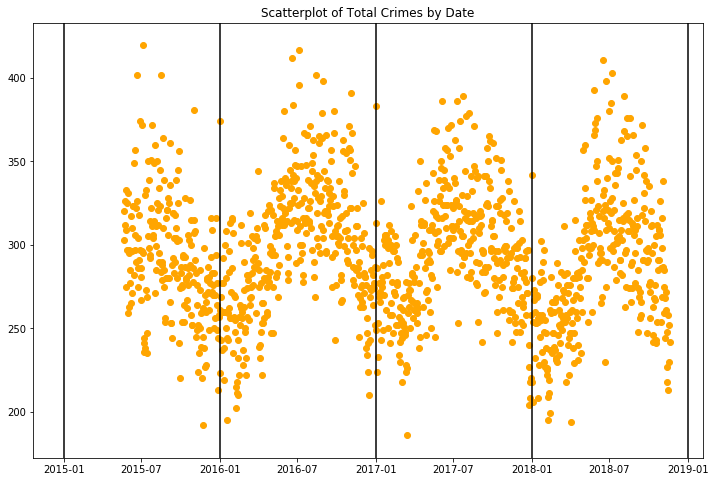

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))

for i, v in crime_count.iteritems():
    plt.scatter(i, v, color = "orange")

plt.axvline(x = "2015-01-01", color = "black")
plt.axvline(x = "2016-01-01", color = "black")
plt.axvline(x = "2017-01-01", color = "black")
plt.axvline(x = "2018-01-01", color = "black")
plt.axvline(x = "2019-01-01", color = "black")
plt.title("Scatterplot of Total Crimes by Date")
plt.show()

### View Statistical Information

In [29]:
crime_data_updated.describe()

,High Crime Day?,Air_Temperature,Humidity,Rain,Wind_Speed,Barometric_Pressure,BC_Daily_Change,DOW_Daily_Change,Holiday?
count,1280.000000,1271.000000,1271.000000,1271.000000,1271.000000,1267.000000,1280.000000,884.000000,1280.000000
mean,0.253125,11.778168,66.071694,0.149257,3.164299,993.845771,3.145203,0.986837,0.089063
std,0.434972,10.233056,12.132837,0.556031,1.412045,6.582052,295.961063,157.405457,0.284945
min,0.000000,-19.305417,25.958333,0.000000,0.766667,970.991667,-2345.600000,-1041.839843,0.000000
25%,0.000000,3.770417,57.613872,0.000000,2.120833,989.823370,-9.362500,-56.395996,0.000000
50%,0.000000,12.908889,66.750000,0.000000,2.930000,993.679167,1.500000,8.800782,0.000000
75%,1.000000,20.699347,75.651515,0.028949,3.952277,997.981250,24.852500,73.819824,0.000000
max,1.000000,30.348182,91.173913,13.382083,9.795455,1015.971429,3633.600000,827.599609,1.000000


### Determine How to Handle Null Values

In [30]:
crime_data_updated.isnull().sum()

Date                      0
High Crime Day?           0
Air_Temperature           9
Humidity                  9
Rain                      9
Wind_Speed                9
Barometric_Pressure      13
BC_Daily_Change           0
DOW_Daily_Change        396
Cubs_H/A                681
Cubs_Opp                681
Cubs_Result             681
Sox_H/A                 680
Sox_Opp                 680
Sox_Result              680
Basketball_H/A         1028
Basketball_Opp         1028
Basketball_Result      1028
Football_Result        1240
Football_H/A           1240
Football_Opp           1240
Hockey_H/A              992
Hockey_Opp              992
Hockey_Result           992
Holiday?                  0
dtype: int64

In [31]:
for index, row in crime_data_updated.iterrows():
    if ((row["Cubs_H/A"] not in ["Home", "Away"]) & 
        (row["Sox_H/A"] not in ["Home", "Away"]) &
        (row["Basketball_H/A"] not in ["Home", "Away"]) &
        (row["Football_H/A"] not in ["Home", "Away"]) &
        (row["Hockey_H/A"] not in ["Home", "Away"])):
        crime_data_updated.loc[index, "Home Game"] = "NA"
        crime_data_updated.loc[index, "Fan Morale"] = "Neutral"
    else:
        if ((row["Cubs_H/A"] == "Home") | 
            (row["Sox_H/A"] == "Home") | 
            (row["Basketball_H/A"] == "Home") |
            (row["Football_H/A"] == "Home") | 
            (row["Hockey_H/A"] == "Home")):
            crime_data_updated.loc[index, "Home Game"] = "Yes"
        else:
            crime_data_updated.loc[index, "Home Game"] = "No"
        
        results_set = set()
        results_set.add(row["Cubs_Result"])
        results_set.add(row["Sox_Result"])
        results_set.add(row["Basketball_Result"])
        results_set.add(row["Football_Result"])
        results_set.add(row["Hockey_Result"])
        
        if (("W" in results_set) & ("L" not in results_set)):
            crime_data_updated.loc[index, "Fan Morale"] = "Good"
        elif (("L" in results_set) & ("W" not in results_set)):
            crime_data_updated.loc[index, "Fan Morale"] = "Bad"
        else:
            crime_data_updated.loc[index, "Fan Morale"] = "Neutral"

crime_data_updated = crime_data_updated.drop(["Cubs_H/A", "Cubs_Opp", "Cubs_Result", 
                                             "Sox_H/A", "Sox_Opp", "Sox_Result", 
                                             "Basketball_H/A", "Basketball_Opp", "Basketball_Result", 
                                             "Football_H/A", "Football_Opp", "Football_Result", 
                                             "Hockey_H/A", "Hockey_Opp", "Hockey_Result"], axis = 1)


features = ["Barometric_Pressure", "Wind_Speed", "Air_Temperature", "Rain", "Humidity"]
for feature in features:
    crime_data_updated[feature] = crime_data_updated[feature].fillna(crime_data_updated[feature].mean())
    
crime_data_updated["DOW_Daily_Change"] = crime_data_updated["DOW_Daily_Change"].fillna(0)

crime_data_updated.isnull().sum()

Date                   0
High Crime Day?        0
Air_Temperature        0
Humidity               0
Rain                   0
Wind_Speed             0
Barometric_Pressure    0
BC_Daily_Change        0
DOW_Daily_Change       0
Holiday?               0
Home Game              0
Fan Morale             0
dtype: int64

### View Histograms

Wind_Speed


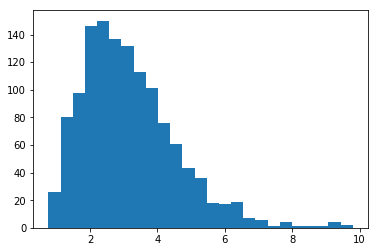

Air_Temperature


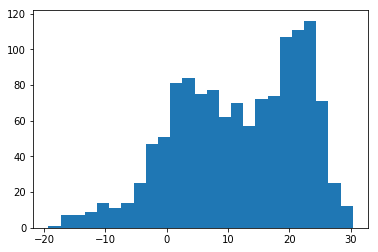

Rain


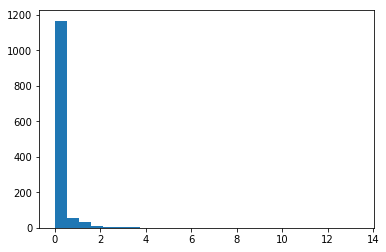

Humidity


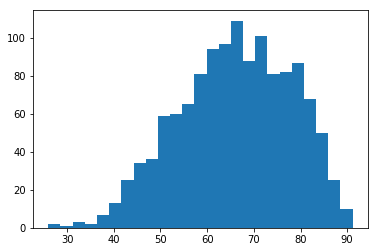

In [32]:
features = ["Wind_Speed", "Air_Temperature", "Rain", "Humidity"]

bins = 25

for feature in features:
    print(feature)
    plt.hist(crime_data_updated[feature], bins = bins)
    plt.show()

Wind_Speed (Log)


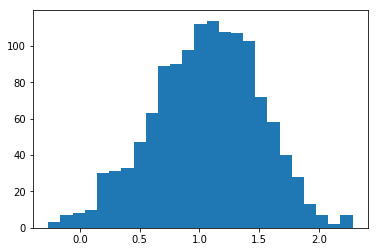

Rain (Log)


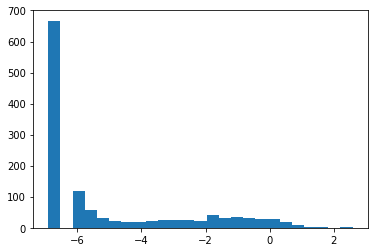

Humidity (Log)


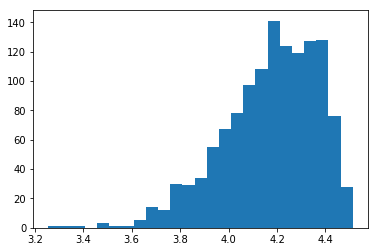

In [33]:
import math

features = ["Wind_Speed", "Rain", "Humidity"]

bins = 25

for feature in features:
    print(feature, "(Log)")
    temp = crime_data_updated[feature].apply(lambda x: math.log(x+0.001))
    plt.hist(temp, bins = bins)
    plt.show()

Wind_Speed


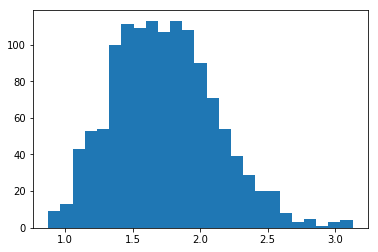

Rain


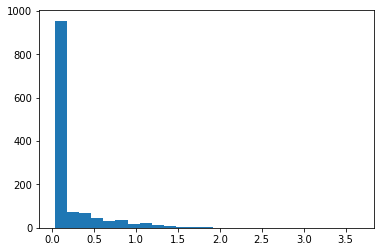

Humidity


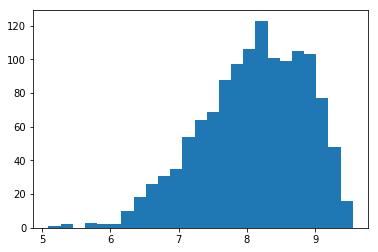

In [34]:
import math

features = ["Wind_Speed", "Rain", "Humidity"]

bins = 25

for feature in features:
    print(feature)
    temp = crime_data_updated[feature].apply(lambda x: math.sqrt(x+0.001))
    plt.hist(temp, bins = bins)
    plt.show()

### Update Wind Speed and Rain Variables

In [35]:
crime_data_updated["Wind_Speed"] = crime_data_updated["Wind_Speed"].apply(lambda x: math.log(x+0.001))

In [36]:
crime_data_updated["Rain"] = crime_data_updated["Rain"].apply(lambda x: math.log(x+0.001))

### Scatterplot of Date and Air Temperature by High Crime Day

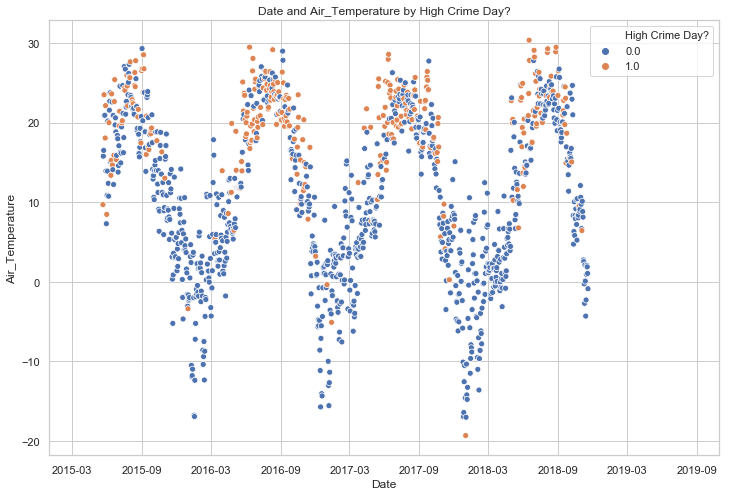

In [37]:
import matplotlib
import seaborn as sns

sns.set(style="whitegrid")

dates = matplotlib.dates.date2num(crime_data_updated["Date"])


f, ax = plt.subplots(figsize = (12, 8))
#sns.despine(f, left = True, bottom = True)
ranks = [0.0, 1.0]
sns.scatterplot(x = crime_data_updated["Date"], y = crime_data_updated["Air_Temperature"], hue = crime_data_updated["High Crime Day?"])
plt.xlim(datetime.datetime.strptime("01-01-2015", "%d-%m-%Y").date(), )
plt.title("Date and Air_Temperature by High Crime Day?")
plt.show()

## Benchmark - Naive Predictor

In [38]:
print(crime_data_updated.groupby("High Crime Day?")["High Crime Day?"].count())
print("\nNaïve Predictor = 324 (# of high crime days) / 1280 (# of total days) = 0.253125")

High Crime Day?
0.0    956
1.0    324
Name: High Crime Day?, dtype: int64

Naïve Predictor = 324 (# of high crime days) / 1280 (# of total days) = 0.253125


In [39]:
from sklearn.metrics import roc_auc_score

pred = []
for i in range(1280):
    pred.append(1)
    
roc_auc_score(crime_data_updated["High Crime Day?"], pred)

0.5

## Execution

### Data Preprocessing

In [40]:
crime_data_updated.head()

,Date,High Crime Day?,Air_Temperature,Humidity,Rain,Wind_Speed,Barometric_Pressure,BC_Daily_Change,DOW_Daily_Change,Holiday?,Home Game,Fan Morale
0,2015-05-22,1.0,9.695000,60.000000,-6.907755,0.811375,993.845771,5.03,-54.849610,0.0,Yes,Neutral
1,2015-05-23,0.0,15.784000,52.533333,-6.907755,0.776722,993.845771,-1.42,0.000000,1.0,Yes,Neutral
2,2015-05-24,0.0,16.507368,67.105263,-0.491797,0.605724,993.845771,1.97,0.000000,1.0,Yes,Bad
3,2015-05-25,1.0,23.500000,62.173913,-1.794459,1.635385,993.845771,-3.82,0.000000,1.0,Yes,Bad
4,2015-05-26,0.0,20.851500,74.400000,-0.473209,1.382788,986.875000,0.02,-188.210937,0.0,Yes,Neutral


In [41]:
targets = crime_data_updated["High Crime Day?"]
features = crime_data_updated.drop(["High Crime Day?", "Date"], axis = 1)

### Min-Max Scaler

In [42]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() # default=(0, 1)
numerical = ["Air_Temperature", "Humidity", "Rain", "Wind_Speed", "Barometric_Pressure", "BC_Daily_Change", "DOW_Daily_Change"]

features[numerical] = scaler.fit_transform(features[numerical])

# Show an example of a record with scaling applied
display(features.head(n = 5))

,Air_Temperature,Humidity,Rain,Wind_Speed,Barometric_Pressure,BC_Daily_Change,DOW_Daily_Change,Holiday?,Home Game,Fan Morale
0,0.584055,0.521987,0.000000,0.422465,0.508097,0.393135,0.527961,0.0,Yes,Neutral
1,0.706684,0.407495,0.000000,0.408857,0.508097,0.392056,0.557301,1.0,Yes,Neutral
2,0.721253,0.630937,0.675240,0.341705,0.508097,0.392623,0.557301,1.0,Yes,Bad
3,0.862081,0.555321,0.538143,0.746061,0.508097,0.391654,0.557301,1.0,Yes,Bad
4,0.808741,0.742793,0.677196,0.646864,0.353122,0.392297,0.456623,0.0,Yes,Neutral


### One-Hot Encoding

In [43]:
features = pd.get_dummies(features)

encoded = list(features.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))
print(encoded)

14 total features after one-hot encoding.
['Air_Temperature', 'Humidity', 'Rain', 'Wind_Speed', 'Barometric_Pressure', 'BC_Daily_Change', 'DOW_Daily_Change', 'Holiday?', 'Home Game_NA', 'Home Game_No', 'Home Game_Yes', 'Fan Morale_Bad', 'Fan Morale_Good', 'Fan Morale_Neutral']


### Shuffle / Split Data

In [44]:
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    targets, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 1024 samples.
Testing set has 256 samples.


C:\Users\wesle\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Implementation

### Create Training and Predicting Pipeline

In [45]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    outputs:
       - results['pred_time']: time model took to complete predictions
       - results['auroc_train']: AUROC value on the training data
       - results['auroc_test']: AUROC value on the testing data
    '''
    
    # Train the model
    results = {}
    start = time() # Get start time
    learner.fit(X_train[0:sample_size], y_train[0:sample_size])
    end = time() # Get end time
    results['train_time'] = end - start
    
    # Use trained model to complete predictions
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
    results['pred_time'] = end - start
    
    # Calculate results
    results['auroc_train'] = roc_auc_score(y_train, predictions_train)
    results['auroc_test'] = roc_auc_score(y_test, predictions_test)
    
    # Print out success statement
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
    
    # Return results
    return results

### Initial Model Evaluation

In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import linear_model
from time import time
import pprint

clf_A = DecisionTreeClassifier(random_state = 0)
clf_B = SVC(random_state = 0)
clf_C = linear_model.LogisticRegression(random_state = 0)

samples_100 = len(y_train)
samples_10 = len(y_train)/10
samples_1 = len(y_train)/100

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        samples = int(samples)
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

pprint.pprint(results)

DecisionTreeClassifier trained on 10 samples.
DecisionTreeClassifier trained on 102 samples.
DecisionTreeClassifier trained on 1024 samples.
SVC trained on 10 samples.
SVC trained on 102 samples.
SVC trained on 1024 samples.
LogisticRegression trained on 10 samples.
LogisticRegression trained on 102 samples.
LogisticRegression trained on 1024 samples.
{'DecisionTreeClassifier': {0: {'auroc_test': 0.57276570048309172,
                                'auroc_train': 0.50139814129451432,
                                'pred_time': 0.0,
                                'train_time': 0.002991199493408203},
                            1: {'auroc_test': 0.70803140096618356,
                                'auroc_train': 0.71711283822682781,
                                'pred_time': 0.0,
                                'train_time': 0.0009968280792236328},
                            2: {'auroc_test': 0.70199275362318847,
                                'auroc_train': 1.0,
                  

## Refinement

In [47]:
from sklearn import grid_search
from sklearn.metrics import make_scorer

clf = DecisionTreeClassifier(random_state = 0)

parameters = {"criterion" : ["gini", "entropy"], "splitter": ["best", "random"], "max_depth": [None, 5, 10, 15, 20, 25], 
             "min_samples_split": [2, 5, 10, 15, 20, 25], "min_samples_leaf": [1, 2, 5, 10, 15, 20, 25], 
             "min_weight_fraction_leaf": [0.0, 0.1, 0.2], "max_features": [None, "log2", "sqrt", "auto"],
             "max_leaf_nodes": [None, 5, 10, 15, 20, 25], "min_impurity_decrease": [0.0, 0.01, 0.1],
             "class_weight": [None, "balanced"], "presort": [True, False]}

scorer = make_scorer(roc_auc_score)

grid_obj = grid_search.GridSearchCV(clf, parameters, scorer)

grid_fit = grid_obj.fit(X_train, y_train)

best_clf = grid_fit.best_estimator_

predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

C:\Users\wesle\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [48]:
# Report the before-and-afterscores
print("Unoptimized model\n------")
print("AUROC on testing data: " + "0.702")
print("\nOptimized Model\n------")
print("AUROC on the testing data: {:.4f}".format(roc_auc_score(y_test, best_predictions)))
print("\nBest CLF\n------")
print(best_clf)

Unoptimized model
------
AUROC on testing data: 0.702

Optimized Model
------
AUROC on the testing data: 0.7678

Best CLF
------
DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=10,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=True, random_state=0,
            splitter='best')


In [49]:
print(list(X_train))
print(best_clf.feature_importances_)

['Air_Temperature', 'Humidity', 'Rain', 'Wind_Speed', 'Barometric_Pressure', 'BC_Daily_Change', 'DOW_Daily_Change', 'Holiday?', 'Home Game_NA', 'Home Game_No', 'Home Game_Yes', 'Fan Morale_Bad', 'Fan Morale_Good', 'Fan Morale_Neutral']
[ 0.64638872  0.          0.07026347  0.          0.          0.03281124
  0.25053657  0.          0.          0.          0.          0.          0.
  0.        ]


In [50]:
importances = best_clf.feature_importances_

from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(roc_auc_score(y_test, best_predictions)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(roc_auc_score(y_test, reduced_predictions)))

Final Model trained on full data
------
Accuracy on testing data: 0.7678

Final Model trained on reduced data
------
Accuracy on testing data: 0.7678


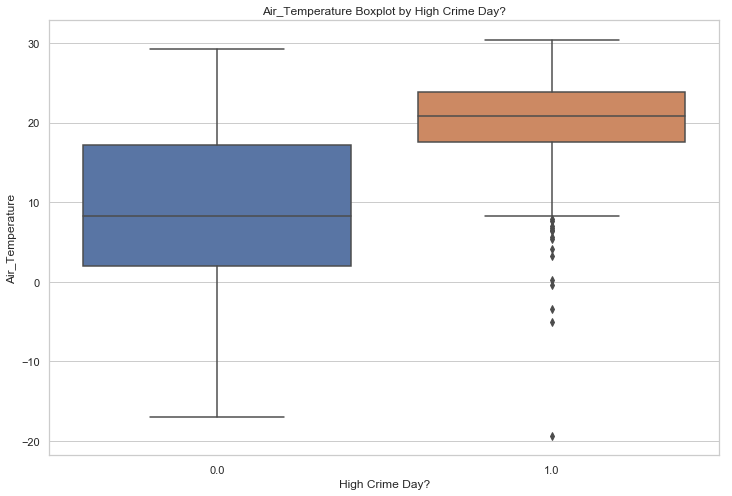

In [51]:
sns.set(style="whitegrid")

#dates = matplotlib.dates.date2num(crime_data_updated["Date"])


f, ax = plt.subplots(figsize = (12, 8))
#sns.despine(f, left = True, bottom = True)
#ranks = [0.0, 1.0]
sns.boxplot(x = crime_data_updated["High Crime Day?"], y = crime_data_updated["Air_Temperature"])
plt.title("Air_Temperature Boxplot by High Crime Day?")
plt.show()